# DenseNet-BC implementation with PyTorch

In [ ]:
import time
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import random
import torchsummary

In [ ]:
print(torch.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

1.9.0+cu102
cuda:0


In [ ]:
validation_ratio = 0.1
random_seed = 10

transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])

transform_validation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])


transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

validset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_validation)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)


num_train = len(trainset)
indices = list(range(num_train))
split = int(np.floor(validation_ratio * num_train))

np.random.seed(random_seed)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Data Loaders
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, sampler=train_sampler, num_workers=0
)

valid_loader = torch.utils.data.DataLoader(
    validset, batch_size=batch_size, sampler=valid_sampler, num_workers=0
)

test_loader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=0
)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class bn_relu_conv(nn.Module):
    def __init__(self, nin, nout, kernel_size, stride, padding, bias=False):
        super(bn_relu_conv, self).__init__()
        self.batch_norm = nn.BatchNorm2d(nin)
        self.relu = nn.ReLU(True)
        self.conv = nn.Conv2d(nin, nout, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)

    def forward(self, x):
        out = self.batch_norm(x)
        out = self.relu(out)
        out = self.conv(out)

        return out

In [ ]:
class bottleneck_layer(nn.Sequential):
  def __init__(self, nin, growth_rate, drop_rate=0.2):    
      super(bottleneck_layer, self).__init__()
      
      self.add_module('conv_1x1', bn_relu_conv(nin=nin, nout=growth_rate*4, kernel_size=1, stride=1, padding=0, bias=False))
      self.add_module('conv_3x3', bn_relu_conv(nin=growth_rate*4, nout=growth_rate, kernel_size=3, stride=1, padding=1, bias=False))
      
      self.drop_rate = drop_rate
      
  def forward(self, x):
      bottleneck_output = super(bottleneck_layer, self).forward(x)
      if self.drop_rate > 0:
          bottleneck_output = F.dropout(bottleneck_output, p=self.drop_rate, training=self.training)
          
      bottleneck_output = torch.cat((x, bottleneck_output), 1)
      
      return bottleneck_output

In [ ]:
class Transition_layer(nn.Sequential):
  def __init__(self, nin, theta=0.5):    
      super(Transition_layer, self).__init__()
      
      self.add_module('conv_1x1', bn_relu_conv(nin=nin, nout=int(nin*theta), kernel_size=1, stride=1, padding=0, bias=False))
      self.add_module('avg_pool_2x2', nn.AvgPool2d(kernel_size=2, stride=2, padding=0))

In [ ]:
class DenseBlock(nn.Sequential):
  def __init__(self, nin, num_bottleneck_layers, growth_rate, drop_rate=0.2):
      super(DenseBlock, self).__init__()
                        
      for i in range(num_bottleneck_layers):
          nin_bottleneck_layer = nin + growth_rate * i
          self.add_module('bottleneck_layer_%d' % i, bottleneck_layer(nin=nin_bottleneck_layer, growth_rate=growth_rate, drop_rate=drop_rate))

In [ ]:
class DenseNet(nn.Module):
    def __init__(self, growth_rate=12, num_layers=100, theta=0.5, drop_rate=0.2, num_classes=10):
        super(DenseNet, self).__init__()
        
        assert (num_layers - 4) % 6 == 0
        
        # (num_layers-4)//6 
        num_bottleneck_layers = (num_layers - 4) // 6
        
        # 32 x 32 x 3 --> 32 x 32 x (growth_rate*2)
        self.dense_init = nn.Conv2d(3, growth_rate*2, kernel_size=3, stride=1, padding=1, bias=True)
                
        # 32 x 32 x (growth_rate*2) --> 32 x 32 x [(growth_rate*2) + (growth_rate * num_bottleneck_layers)]
        self.dense_block_1 = DenseBlock(nin=growth_rate*2, num_bottleneck_layers=num_bottleneck_layers, growth_rate=growth_rate, drop_rate=drop_rate)

        # 32 x 32 x [(growth_rate*2) + (growth_rate * num_bottleneck_layers)] --> 16 x 16 x [(growth_rate*2) + (growth_rate * num_bottleneck_layers)]*theta
        nin_transition_layer_1 = (growth_rate*2) + (growth_rate * num_bottleneck_layers) 
        self.transition_layer_1 = Transition_layer(nin=nin_transition_layer_1, theta=theta)
        
        # 16 x 16 x nin_transition_layer_1*theta --> 16 x 16 x [nin_transition_layer_1*theta + (growth_rate * num_bottleneck_layers)]
        self.dense_block_2 = DenseBlock(nin=int(nin_transition_layer_1*theta), num_bottleneck_layers=num_bottleneck_layers, growth_rate=growth_rate, drop_rate=drop_rate)

        # 16 x 16 x [nin_transition_layer_1*theta + (growth_rate * num_bottleneck_layers)] --> 8 x 8 x [nin_transition_layer_1*theta + (growth_rate * num_bottleneck_layers)]*theta
        nin_transition_layer_2 = int(nin_transition_layer_1*theta) + (growth_rate * num_bottleneck_layers) 
        self.transition_layer_2 = Transition_layer(nin=nin_transition_layer_2, theta=theta)
        
        # 8 x 8 x nin_transition_layer_2*theta --> 8 x 8 x [nin_transition_layer_2*theta + (growth_rate * num_bottleneck_layers)]
        self.dense_block_3 = DenseBlock(nin=int(nin_transition_layer_2*theta), num_bottleneck_layers=num_bottleneck_layers, growth_rate=growth_rate, drop_rate=drop_rate)
        
        nin_fc_layer = int(nin_transition_layer_2*theta) + (growth_rate * num_bottleneck_layers) 
        
        # [nin_transition_layer_2*theta + (growth_rate * num_bottleneck_layers)] --> num_classes
        self.fc_layer = nn.Linear(nin_fc_layer, num_classes)
        
    def forward(self, x):
        dense_init_output = self.dense_init(x)
        
        dense_block_1_output = self.dense_block_1(dense_init_output)
        transition_layer_1_output = self.transition_layer_1(dense_block_1_output)
        
        dense_block_2_output = self.dense_block_2(transition_layer_1_output)
        transition_layer_2_output = self.transition_layer_2(dense_block_2_output)
        
        dense_block_3_output = self.dense_block_3(transition_layer_2_output)
        
        global_avg_pool_output = F.adaptive_avg_pool2d(dense_block_3_output, (1, 1))                
        global_avg_pool_output_flat = global_avg_pool_output.view(global_avg_pool_output.size(0), -1)

        output = self.fc_layer(global_avg_pool_output_flat)
        
        return output

In [ ]:
def DenseNetBC_100_12():
    return DenseNet(growth_rate=12, num_layers=100, theta=0.5, drop_rate=0.2, num_classes=10)

In [ ]:
densenetBC = DenseNetBC_100_12()

In [ ]:
densenetBC.to(device)

DenseNet(
  (dense_init): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dense_block_1): DenseBlock(
    (bottleneck_layer_0): bottleneck_layer(
      (conv_1x1): bn_relu_conv(
        (batch_norm): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (conv_3x3): bn_relu_conv(
        (batch_norm): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
    )
    (bottleneck_layer_1): bottleneck_layer(
      (conv_1x1): bn_relu_conv(
        (batch_norm): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv): Conv2d(36, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
   

In [ ]:
torchsummary.summary(densenetBC, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 32, 32]             672
       BatchNorm2d-2           [-1, 24, 32, 32]              48
              ReLU-3           [-1, 24, 32, 32]               0
            Conv2d-4           [-1, 48, 32, 32]           1,152
      bn_relu_conv-5           [-1, 48, 32, 32]               0
       BatchNorm2d-6           [-1, 48, 32, 32]              96
              ReLU-7           [-1, 48, 32, 32]               0
            Conv2d-8           [-1, 12, 32, 32]           5,184
      bn_relu_conv-9           [-1, 12, 32, 32]               0
      BatchNorm2d-10           [-1, 36, 32, 32]              72
             ReLU-11           [-1, 36, 32, 32]               0
           Conv2d-12           [-1, 48, 32, 32]           1,728
     bn_relu_conv-13           [-1, 48, 32, 32]               0
      BatchNorm2d-14           [-1, 48,

In [ ]:
# Hyperparameters
batch_size = 64
learning_rate = 0.1
num_epoch = 40
loss_vector = []


start = time.time()

# Oprimization Criteria and Optimization method
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(densenetBC.parameters(), lr=learning_rate, momentum=0.9)
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[int(num_epoch * 0.5), int(num_epoch * 0.75)], gamma=0.1, last_epoch=-1)

# Training Loop
for epoch in range(num_epoch):  
    lr_scheduler.step()
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = densenetBC(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        show_period = 100
        if i % show_period == show_period-1:    # print every "show_period" mini-batches
            loss_vector.append(running_loss / show_period)
            print('[%d, %5d/50000] loss: %.7f' %
                  (epoch + 1, (i + 1)*batch_size, running_loss / show_period))
            running_loss = 0.0
        
        
    # validation part
    correct = 0
    total = 0
    for i, data in enumerate(valid_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = densenetBC(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print('[%d epoch] Accuracy of the network on the validation images: %d %%' % 
          (epoch + 1, 100 * correct / total)
         )

print('Finished Training')
end = time.time() # Time counted in seconds
print(f"The total time to train the model on the K80 GPU is : {((end - start)/60):.1f} minutes.")

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[1,  6400/50000] loss: 1.9896438
[1, 12800/50000] loss: 1.8472652
[1, 19200/50000] loss: 1.7422154
[1, 25600/50000] loss: 1.6270522
[1, 32000/50000] loss: 1.5546020
[1, 38400/50000] loss: 1.4678522
[1, 44800/50000] loss: 1.4017360
[1 epoch] Accuracy of the network on the validation images: 42 %
[2,  6400/50000] loss: 1.3521483
[2, 12800/50000] loss: 1.2921677
[2, 19200/50000] loss: 1.2528612
[2, 25600/50000] loss: 1.1459972
[2, 32000/50000] loss: 1.1028980
[2, 38400/50000] loss: 1.0719605
[2, 44800/50000] loss: 1.0964580
[2 epoch] Accuracy of the network on the validation images: 55 %
[3,  6400/50000] loss: 1.0502053
[3, 12800/50000] loss: 0.9985137
[3, 19200/50000] loss: 0.9693762
[3, 25600/50000] loss: 0.9674620
[3, 32000/50000] loss: 0.8693732
[3, 38400/50000] loss: 0.8971371
[3, 44800/50000] loss: 0.9046278
[3 epoch] Accuracy of the network on the validation images: 65 %
[4,  6400/50000] loss: 0.8780809
[4, 12800/50000] loss: 0.8545940
[4, 19200/50000] loss: 0.8556324
[4, 25600/500

x = range(0, 280)
loss_vector = [1.9896437919139862, 1.8472651755809784, 1.742215371131897, 1.627052229642868, 1.5546020400524139, 1.467852166891098, 1.401735965013504, 1.3521482706069947, 1.2921676874160766, 1.2528611940145493, 1.1459972339868545, 1.1028979671001435, 1.0719605374336243, 1.096458038687706, 1.0502052944898606, 0.9985136717557908, 0.9693761670589447, 0.9674620050191879, 0.8693731671571732, 0.8971370634436607, 0.9046278232336045, 0.8780809390544891, 0.8545940124988556, 0.8556323623657227, 0.7780161234736442, 0.7971866172552109, 0.7591564273834228, 0.7330044654011726, 0.7515835383534432, 0.7076417708396912, 0.7071316942572594, 0.6994009691476822, 0.6765867730975151, 0.6906430661678314, 0.6774377086758614, 0.6672927758097649, 0.6543112993240356, 0.6281163328886032, 0.6404517138004303, 0.6142701935768128, 0.614784369468689, 0.591631892323494, 0.6228656607866287, 0.5582725363969803, 0.5769671449065208, 0.5908145615458489, 0.5703697320818901, 0.5221429285407067, 0.563297893702

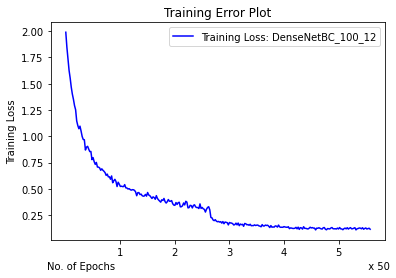

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

x = range(len(loss_vector))
x_epoch = [z for z in range(1, len(loss_vector)+1) if z%50 == 0] 
x_ticks_labels = [str(x) for x in range(1, 40)]

plt.figure(1)
print(f"x = {x}")
print(f"loss_vector = {loss_vector}")
print()
plt.plot(x, loss_vector, color = 'b', label = "Training Loss: DenseNetBC_100_12")
plt.xticks(x_epoch, x_ticks_labels)
plt.title("Training Error Plot")
plt.ylabel("Training Loss")
plt.xlabel("No. of Epochs                                                                                 x 50")
plt.legend()
plt.savefig("training_error_plot.png", dpi = 300) # to save your plot
plt.show()

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = densenetBC(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
                
        for i in range(labels.shape[0]):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))            
            
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
print()
print("You have reached the end of Engelbert's implemenetation")

Accuracy of the network on the 10000 test images: 86 %
Accuracy of plane : 87 %
Accuracy of   car : 91 %
Accuracy of  bird : 84 %
Accuracy of   cat : 76 %
Accuracy of  deer : 84 %
Accuracy of   dog : 81 %
Accuracy of  frog : 89 %
Accuracy of horse : 90 %
Accuracy of  ship : 92 %
Accuracy of truck : 90 %

You have reached the end of Engelbert's implemenetation
